In [1]:
import numpy as np
import torch
import torch.nn as nn
import art.attacks.evasion as toolbox
from art.estimators.classification import PyTorchClassifier
from torchvision import transforms
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
# from kd_export import LightNN
# from mvtec import test_dataset

d:\Arcade Projects\Knowledge_Distillation_Testing\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Check current device: ")
# Check if GPU is available, and if not, use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): # Should return True 
    print(f"Using GPU: {torch.cuda.get_device_name(0)}") # Should show your GPU name
else:
    print("Using CPU")

Check current device: 
Using GPU: NVIDIA GeForce RTX 4060


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Loading the CIFAR-10 dataset: (train set will later be split into train and val)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)

In [4]:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [5]:
# epsilons = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95]
# Create the list based on the given parameters
eps_res = 32
eps_min = 1e-9  # Correcting the spacing issue in the input
eps_max = 1.0

# Generating the list of values
eps_list = [eps_min + i * (eps_max - eps_min) / (eps_res - 1) for i in range(eps_res)]

pretrained_model_KD = "student_model_KD_cf10.pth"
use_cuda=True

# Initialize the network
torch.manual_seed(42)
model_KD = LightNN(num_classes=10).to(device)

# Load the pretrained model
model_KD.load_state_dict(torch.load(pretrained_model_KD, map_location=device, weights_only=True))

# Set the model in evaluation mode
model_KD.eval()

LightNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [6]:
# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_KD.parameters(), lr=0.001)

# Wrap the model with PyTorchClassifier
classifier = PyTorchClassifier(
    model=model_KD,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 224, 224),  # Adjust to your input shape
    nb_classes=10              # Number of output classes
)

In [7]:
print(test_dataset)
test_image = np.array([data[0].numpy() for data in test_dataset])
test_label = np.array([data[1] for data in test_dataset])

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [8]:
fgsm_accuracy_list = []
for eps in eps_list:
    # Create FGSM attack
    attack = toolbox.FastGradientMethod(estimator=classifier, eps=eps)

    # Generate adversarial examples
    x_test_adv_fgsm = attack.generate(x=test_image)

    # Evaluate accuracy on adversarial examples
    predictions = classifier.predict(x_test_adv_fgsm)
    accuracy = np.sum(np.argmax(predictions, axis=1) == test_label) / len(test_label)
    fgsm_accuracy_list.append(accuracy)
    print(f"Accuracy on FSGM attack with epsilon {eps}: {accuracy * 100:.2f}%")

Accuracy on FSGM attack with epsilon 1e-09: 70.40%
Accuracy on FSGM attack with epsilon 0.03225806548387097: 39.94%
Accuracy on FSGM attack with epsilon 0.06451612996774193: 23.21%
Accuracy on FSGM attack with epsilon 0.09677419445161291: 17.11%
Accuracy on FSGM attack with epsilon 0.12903225893548387: 14.71%
Accuracy on FSGM attack with epsilon 0.16129032341935484: 13.49%
Accuracy on FSGM attack with epsilon 0.19354838790322582: 12.65%
Accuracy on FSGM attack with epsilon 0.2258064523870968: 11.93%
Accuracy on FSGM attack with epsilon 0.25806451687096776: 11.24%
Accuracy on FSGM attack with epsilon 0.2903225813548388: 10.84%
Accuracy on FSGM attack with epsilon 0.3225806458387097: 10.52%
Accuracy on FSGM attack with epsilon 0.3548387103225807: 10.21%
Accuracy on FSGM attack with epsilon 0.38709677480645166: 10.10%
Accuracy on FSGM attack with epsilon 0.41935483929032263: 10.02%
Accuracy on FSGM attack with epsilon 0.4516129037741936: 10.06%
Accuracy on FSGM attack with epsilon 0.48387

In [9]:
pgd_accuracy_list = []
for eps in eps_list:
    # Create PGD attack
    pgd_attack = toolbox.ProjectedGradientDescent(estimator=classifier, eps=eps)

    # Generate adversarial examples
    x_test_adv_pgd = pgd_attack.generate(x=test_image)

    # Evaluate accuracy on adversarial examples
    predictions = classifier.predict(x_test_adv_pgd)
    accuracy = np.sum(np.argmax(predictions, axis=1) == test_label) / len(test_label)
    pgd_accuracy_list.append(accuracy)
    print(f"Accuracy on PGD attack with epsilon {eps}: {accuracy * 100:.2f}%")

Accuracy on PGD attack with epsilon 1e-09: 70.40%


Accuracy on PGD attack with epsilon 0.03225806548387097: 36.31%


Accuracy on PGD attack with epsilon 0.06451612996774193: 15.00%


Accuracy on PGD attack with epsilon 0.09677419445161291: 10.91%


Accuracy on PGD attack with epsilon 0.12903225893548387: 10.54%


Accuracy on PGD attack with epsilon 0.16129032341935484: 10.27%


Accuracy on PGD attack with epsilon 0.19354838790322582: 10.16%


Accuracy on PGD attack with epsilon 0.2258064523870968: 10.08%


Accuracy on PGD attack with epsilon 0.25806451687096776: 10.01%


Accuracy on PGD attack with epsilon 0.2903225813548388: 10.00%


Accuracy on PGD attack with epsilon 0.3225806458387097: 9.89%


Accuracy on PGD attack with epsilon 0.3548387103225807: 9.89%


Accuracy on PGD attack with epsilon 0.38709677480645166: 9.81%


Accuracy on PGD attack with epsilon 0.41935483929032263: 9.79%


Accuracy on PGD attack with epsilon 0.4516129037741936: 9.69%


Accuracy on PGD attack with epsilon 0.4838709682580646: 9.70%


Accuracy on PGD attack with epsilon 0.5161290327419354: 9.70%


Accuracy on PGD attack with epsilon 0.5483870972258065: 9.72%


Accuracy on PGD attack with epsilon 0.5806451617096775: 9.67%


Accuracy on PGD attack with epsilon 0.6129032261935484: 9.67%


Accuracy on PGD attack with epsilon 0.6451612906774193: 9.63%


Accuracy on PGD attack with epsilon 0.6774193551612904: 9.65%


Accuracy on PGD attack with epsilon 0.7096774196451613: 9.64%


Accuracy on PGD attack with epsilon 0.7419354841290323: 9.63%


Accuracy on PGD attack with epsilon 0.7741935486129032: 9.63%


Accuracy on PGD attack with epsilon 0.8064516130967743: 9.64%


Accuracy on PGD attack with epsilon 0.8387096775806452: 9.64%


Accuracy on PGD attack with epsilon 0.8709677420645161: 9.59%


Accuracy on PGD attack with epsilon 0.9032258065483871: 9.62%


Accuracy on PGD attack with epsilon 0.935483871032258: 9.63%


Accuracy on PGD attack with epsilon 0.9677419355161291: 9.62%


Accuracy on PGD attack with epsilon 1.0: 9.62%


<Figure size 640x480 with 0 Axes>

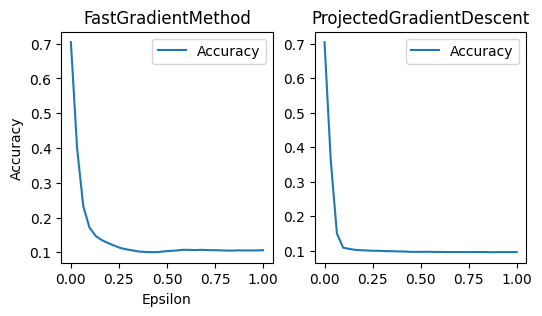

In [10]:
plt.suptitle("Student in Knowledge Distillation under adversarial attacks", fontsize=16)

# Visualize the accuracy drop in FGSM
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.plot(eps_list, fgsm_accuracy_list, label="Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epsilon")
plt.legend(loc='upper right')
plt.title('FastGradientMethod')

# Visualize the accuracy drop in PDG
plt.subplot(1, 2, 2)
plt.plot(eps_list, pgd_accuracy_list, label="Accuracy")
# plt.axhline(y=test_accuracy_light_ce_and_kd, color='red', linestyle='--', label='Test Accuracy')
plt.legend(loc='upper right')
plt.title('ProjectedGradientDescent')
plt.show()

In [11]:
# # Create C&W attack
# cw2_attack = toolbox.CarliniL2Method(classifier=classifier, confidence=0.0, max_iter=40, learning_rate=0.01)

# # Generate adversarial examples
# x_test_adv_cw2 = cw2_attack.generate(x=x_test)

# # Evaluate accuracy on adversarial examples
# predictions = classifier.predict(x_test_adv_cw2)
# accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
# print(f"Accuracy on CW2 attack: {accuracy * 100:.2f}%")

In [12]:
# # Create Universal Perturbations attack
# up_attack = toolbox.UniversalPerturbation(classifier=classifier, attacker="deepfool",
#                                         #   delta=0.2,
#                                           max_iter=10,
#                                           eps=0.1,
#                                         #   batch_size=32,
#                                         #   verbose=True
#                                         )

# # Generate adversarial examples
# x_test_adv_up = up_attack.generate(x=x_test)

# # Evaluate accuracy on adversarial examples
# predictions = classifier.predict(x_test_adv_up)
# accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
# print(f"Accuracy on UP attack: {accuracy * 100:.2f}%")